In [175]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Data Fetching

In [169]:
# Call the Yelp API

API_KEY = '0637mKfd2w2y3jhpZQcKqP1mOcLmALcuEsbDP4JgqM0Z-uWm-h9SrWy1phqM-EQ2Adv23UWXwdh5_Kvc7ZczfN_f980hbJ7Ip87eencqs_4sSvjN4akq1Akg_Ic6Z3Yx'

headers = {
    'Authorization': f'Bearer {API_KEY}',
    'accept': 'application/json'
}
url = 'https://api.yelp.com/v3/businesses/search'

restaurants = []

# Need to cycle through different offset params to return over 50 results
for offset in range(0, 200, 50):
    params = {
        'location': 'Stouffville, Ontario, Canada',
        'term': 'restaurants',
        'categories': 'restaurants',
        'limit': 50,
        'offset': offset
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        dat = response.json()
        for business in data['businesses']:
            restaurants.append({
                'Name': business['name'],
                'Rating': business.get('rating', None),
                'Review Count': business.get('review_count', None),
                'Price': business.get('price', 'N/A'),
                'Category': ', '.join([category['title'] for category in business['categories']]),
                'Address': ', '.join(business['location'].get('display_address', [])),
                'Phone': business.get('phone', 'N/A'),
                'Attributes': business.get('attributes', {})
            })    
    else:
        print(f'Error {response.status_code}: {response.json()}')
        break

dat = pd.DataFrame(restaurants)
# Export to csv file
dat.to_csv('stouffville_restaurants.csv', index=False, encoding='utf-8')

Data Cleaning

In [170]:
dat = pd.read_csv('markham_restaurants.csv')

In [171]:
dat.head()

,Name,Rating,Review Count,Price,Category,Address,Phone,Attributes
0,Fishbone By The Lake,3.9,130,$$,"Portuguese, Chicken Wings, Pizza","155 Cedarvale Boulevard, Stouffville, ON L4A 7...",1.905591e+10,"{'business_temp_closed': None, 'menu_url': 'ht..."
1,The King's Landing,4.2,170,$$,"Chicken Wings, Canadian (New), Burgers","5946 Main Street, Whitchurch-Stouffville, ON L...",1.905592e+10,"{'business_temp_closed': None, 'menu_url': 'ht..."
2,Hey Moo Moo,4.4,14,NaN,"Noodles, Bubble Tea, Ramen","18 Ringwood Drive, Whitchurch-Stouffville, ON ...",1.647615e+10,"{'business_temp_closed': None, 'menu_url': Non..."
3,Slabtown cider,4.6,25,NaN,"Pizza, Cideries, Steakhouses","4520 Concession Road 6, Uxbridge, ON L9P 1R4, ...",1.416854e+10,"{'business_temp_closed': None, 'menu_url': Non..."
4,Laon Korean Restaurant,4.5,10,NaN,Korean,"1076 Hoover Park Drive, Unit 7, Whitchurch-Sto...",1.365900e+10,"{'business_temp_closed': None, 'menu_url': Non..."


In [172]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          200 non-null    object 
 1   Rating        200 non-null    float64
 2   Review Count  200 non-null    int64  
 3   Price         64 non-null     object 
 4   Category      200 non-null    object 
 5   Address       200 non-null    object 
 6   Phone         196 non-null    float64
 7   Attributes    200 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 12.6+ KB


In [187]:
# Handle missing values
# Lots of restaurants have missing prices, these should be categorized
dat['Price'] = dat['Price'].fillna('Unlisted')

# Remove duplicates
dat = dat.drop_duplicates(['Name', 'Address'])

# Change the format of the Price column
# Legend: Roughly speaking, $=$10 and under, $$=$10-$25, $$$=$25-$25
dat['Price'] = dat['Price'].replace({
    '$': 'Inexpensive',
    '$$': 'Moderately Expensive',
    '$$$': 'Expensive',
    '$$$$': 'Luxury'
})

# # I noticed some restaurants in the dataset are not from Toronto. These should be removed.
# dat = dat[dat['Address'].str.contains('Stouffville', case=False)]

# Identify restaurants have a very high rating (personally chosen to be a rating of >=4.5)
dat['High Quality'] = dat['Rating'].apply(lambda x: True if x>=4.5 else False)

# Find the average number of reviews under its price category
avg_reviews_by_price = dat.groupby('Price')['Review Count'].mean().to_dict()
dat['Average Review Count for Price'] = dat['Price'].map(avg_reviews_by_price)

# Export to csv
dat.to_csv('stouffville_restaurants_cleaned.csv', index=False, encoding='utf-8')

dat.head()


,Name,Rating,Review Count,Price,Category,Address,Phone,Attributes,High Quality,Average Review Count for Price
0,Fishbone By The Lake,3.9,130,Moderately Expensive,"Portuguese, Chicken Wings, Pizza","155 Cedarvale Boulevard, Stouffville, ON L4A 7...",1.905591e+10,"{'business_temp_closed': None, 'menu_url': 'ht...",False,102.909091
1,The King's Landing,4.2,170,Moderately Expensive,"Chicken Wings, Canadian (New), Burgers","5946 Main Street, Whitchurch-Stouffville, ON L...",1.905592e+10,"{'business_temp_closed': None, 'menu_url': 'ht...",False,102.909091
2,Hey Moo Moo,4.4,14,Unlisted,"Noodles, Bubble Tea, Ramen","18 Ringwood Drive, Whitchurch-Stouffville, ON ...",1.647615e+10,"{'business_temp_closed': None, 'menu_url': Non...",False,16.411765
3,Slabtown cider,4.6,25,Unlisted,"Pizza, Cideries, Steakhouses","4520 Concession Road 6, Uxbridge, ON L9P 1R4, ...",1.416854e+10,"{'business_temp_closed': None, 'menu_url': Non...",True,16.411765
4,Laon Korean Restaurant,4.5,10,Unlisted,Korean,"1076 Hoover Park Drive, Unit 7, Whitchurch-Sto...",1.365900e+10,"{'business_temp_closed': None, 'menu_url': Non...",True,16.411765


Exploratory Data Analysis

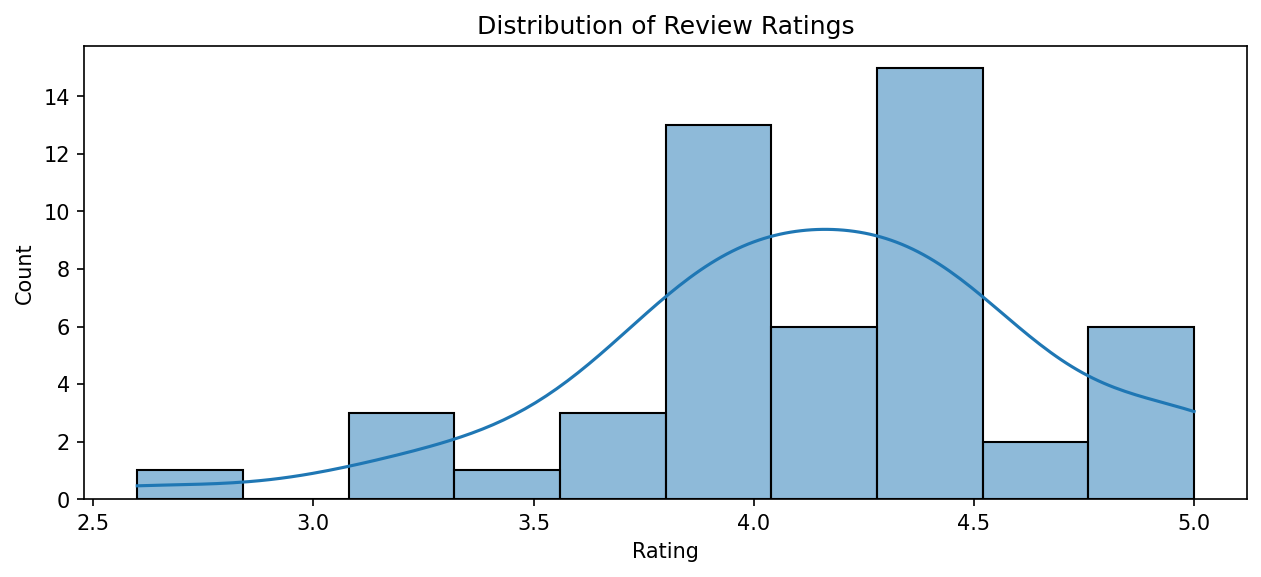

In [177]:
# How does the distribution of review ratings look?
plt.figure(figsize=(10, 4), dpi=150)
sns.histplot(dat['Rating'], bins=10, kde=True)
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Comments
# The bulk of the ratings is between 3.5 and 4.5 which is generally favourable.
# Low ratings (i.e. 2.5 and below) are rarely seen, so restaurants in Stouffville are seen as above average.


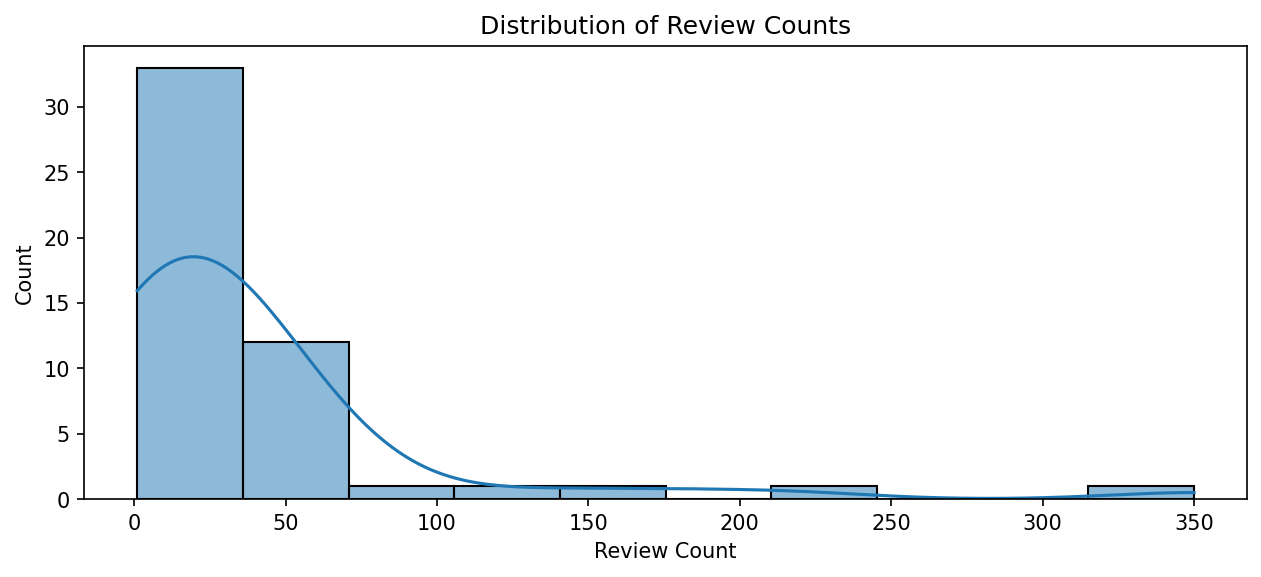

In [178]:
# How does the distribution of rating counts look?
plt.figure(figsize=(10, 4), dpi=150)
sns.histplot(dat['Review Count'], bins=10, kde=True)
plt.title('Distribution of Review Counts')
plt.xlabel('Review Count')
plt.ylabel('Count')
plt.show()

# The histogram is very skewed towards a low review count with a majority of restaurants receiving under 100 reviews.
# It can be seen that customers are not very incentivized to leave a review. A few reasons can be hypothesized:
#    - Low customer interaction doesn't make the customer feel attached to the restaurant
#    - The food is neither not too bad nor too good
#    - Customers don't get asked to leave a review

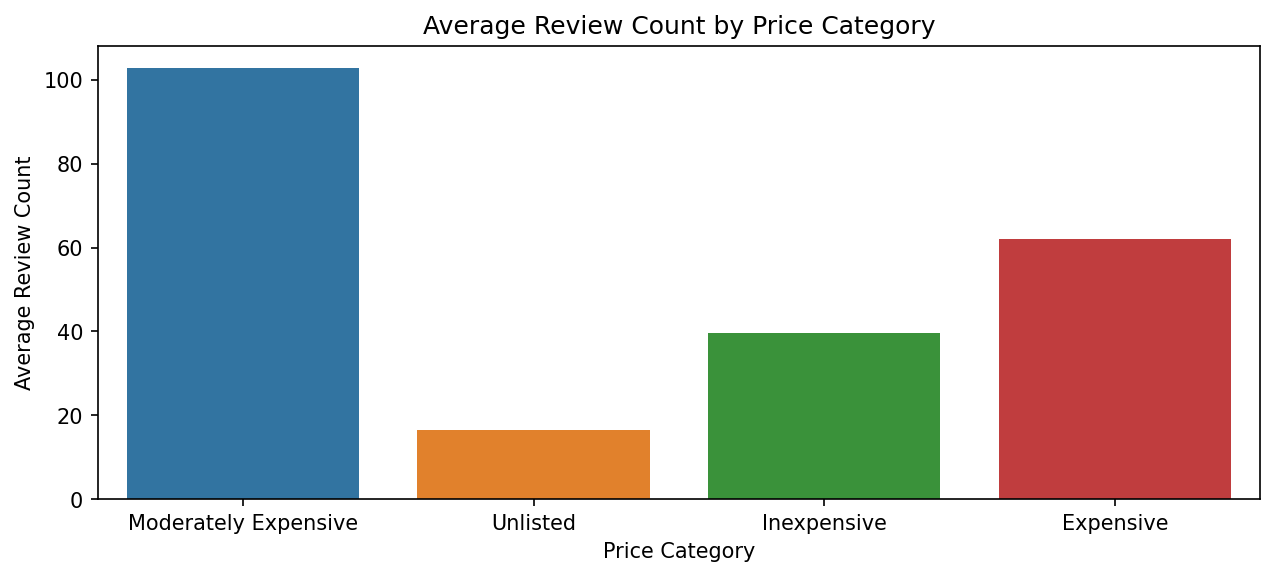

In [192]:
# Question: Do certain price tiers attract more reviews?
## Hypothesis: The pricier the restaurant is, the more the customer is expecting to get out of their experience.
##   They will be more opinionated; if the food is good they will praise it and if it is bad they will be
##   particularly upset and write a review.

plt.figure(figsize=(10, 4), dpi=150)
sns.barplot(data=dat, x='Price', y='Average Review Count for Price')
plt.title('Average Review Count by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Average Review Count')
plt.show()

# On average, moderately expensive restaurants (which are classified as prices from around $10-$25) receive
#    the most reviews followed by expensive restaurants and inexpensive restaurants.
# As I hypothesized, inexpensive restaurants tend to get less reviews possibly because customers
#    But surprisingly, it is the price range inbetween that compels people to leave reviews the most on average.
